In [91]:
import gspread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from google.oauth2.service_account import Credentials

In [2]:
SERVICE_ACCOUNT_FILE = 'key/credentials.json'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets',
          'https://www.googleapis.com/auth/drive']

creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

sheet = client.open('2025 Analyze (Like/Dislike)').worksheet("Raw Data [Statistic form] 2024")
data = sheet.get_all_values()

df = pd.DataFrame(data[1:], columns=data[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172787 entries, 0 to 172786
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Date                     172787 non-null  object
 1   business                 172787 non-null  object
 2   code_type                172787 non-null  object
 3   Code                     172787 non-null  object
 4   solved_num               172787 non-null  object
 5   unsolved_num             172787 non-null  object
 6   Manual Check [business]  172787 non-null  object
 7   Background detail        172787 non-null  object
 8   Team/Category            172787 non-null  object
 9   Week                     172787 non-null  object
 10                           172787 non-null  object
dtypes: object(11)
memory usage: 14.5+ MB


In [31]:
df_loan = df.copy().iloc[:, [0, 5, 7, 8, 9]]
df_loan.columns = df_loan.columns.str.strip()
df_loan['unsolved_num'] = pd.to_numeric(df_loan['unsolved_num'], errors='coerce')

In [21]:
df_loan['Team/Category'].unique()

array(['No Category', 'Voucher', 'Loan', '', 'Account security',
       'Merchant Online', 'Submission of Limit/Credit Points',
       'Global Buy', 'Akulaku Paylater', 'Collection',
       'Installment/Payment Gateway', 'Bug', 'Data Update',
       'Produk Official Store', 'Refund', 'Akulaku Elite Card', 'Bug ',
       'Cari Danaku', 'Produk JD.ID', 'Limit Kredit Bebas Bunga',
       'Insurance', 'SLIK', 'Account Security', 'Promo/lottery/event',
       'Flight ticket', 'Promo/Lotteries/Events', 'Return', 'Account',
       'Electronic Signature', '#N/A', 'Merchant Offline',
       'Refund funds have not returned', 'Loan funds delivery',
       'Akulaku paylater', 'Dana Flexi', 'Akulaku PayLater',
       'Submission of limit/credit points', 'Slik', 'Vouchers',
       'Promo/Undian/Event', 'loan'], dtype=object)

In [156]:
print('Loan, loan, Slik, SLIK, Dana Flexi, Cari Danaku, Collection, Insurance, Loan funds delivery')

Loan, loan, Slik, SLIK, Dana Flexi, Cari Danaku, Collection, Insurance, Loan funds delivery


In [149]:
df_loan_only = df_loan[
    (df_loan['unsolved_num'] != 0) & 
    (df_loan['Team/Category'].isin(['Loan', 'loan'])) & 
    df_loan['Week'].isin(['W4 Sep 2025', 'W1 Oct 2025', 'W2 Oct 2025', 'W3 Oct 2025'])
]

In [148]:
# all related to loan data
df_filtered = df_loan[
    (df_loan['unsolved_num'] != 0) & 
    (df_loan['Team/Category'].isin(['Loan', 'loan', 'Slik', 'SLIK', 'Dana Flexi', 'Cari Danaku', 'Collection', 'Insurance', 'Loan funds delivery'])) & 
    df_loan['Week'].isin(['W4 Sep 2025', 'W1 Oct 2025', 'W2 Oct 2025', 'W3 Oct 2025'])
]

df_filtered

,Date,unsolved_num,Background detail,Team/Category,Week
165078,9/22/2025,2,Loan application verification status,Loan,W4 Sep 2025
165079,9/22/2025,2,Check the remaining loan bill,Loan,W4 Sep 2025
165080,9/22/2025,1,loan limit reduced,Loan,W4 Sep 2025
165081,9/22/2025,1,Unable to pay loan via BCA,Loan,W4 Sep 2025
165082,9/22/2025,2,Loan status has not been successful,Loan,W4 Sep 2025
...,...,...,...,...,...
172047,10/19/2025,1,Repayment of loan bills,Loan,W3 Oct 2025
172056,10/19/2025,1,Loan bill payment has not been received,Loan,W3 Oct 2025
172060,10/19/2025,2,The loan is rejected notif not paying on time,Loan,W3 Oct 2025
172062,10/19/2025,3,Loan application is rejected,Loan,W3 Oct 2025


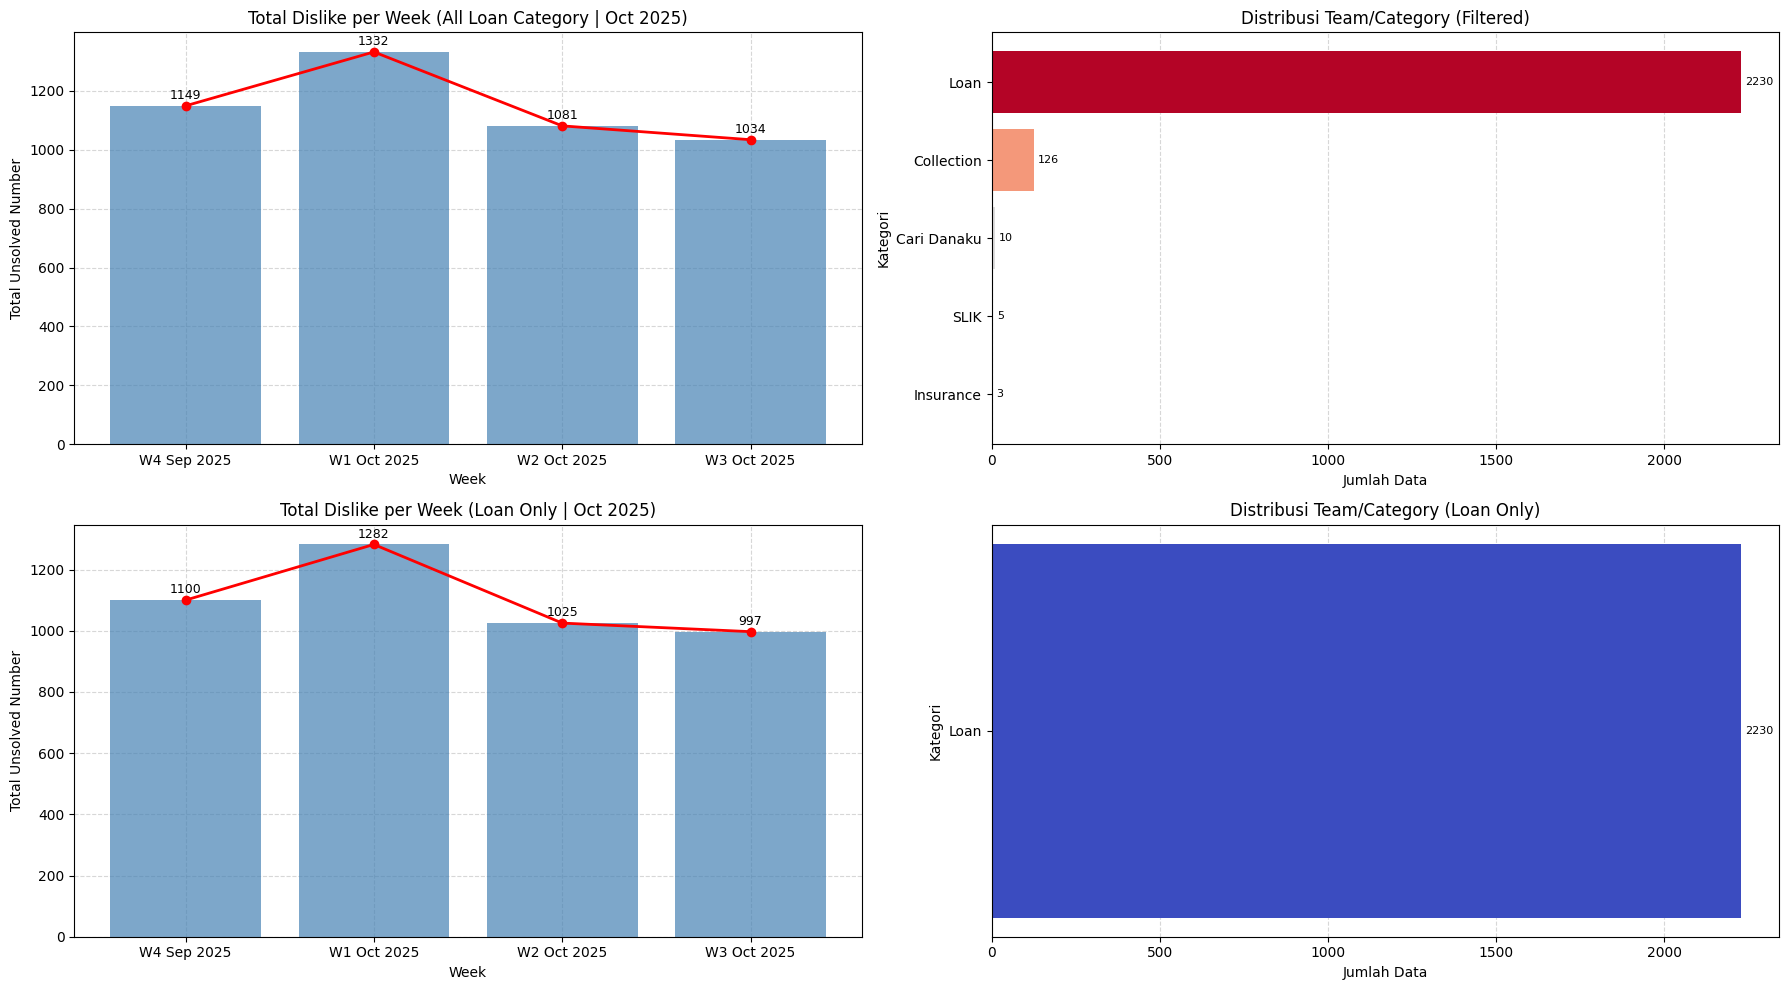

In [154]:
# --- Urutan minggu yang diinginkan ---
custom_order = ['W4 Sep 2025', 'W1 Oct 2025', 'W2 Oct 2025', 'W3 Oct 2025']

# --- Reorder index sesuai urutan custom ---
weekly_sum = df_filtered.groupby('Week')['unsolved_num'].sum().reindex(custom_order)
weekly_sum_2 = df_loan_only.groupby('Week')['unsolved_num'].sum().reindex(custom_order)

# --- Hitung kategori ---
category_counts = df_filtered['Team/Category'].value_counts().sort_values(ascending=True)
category_counts_2 = df_loan_only['Team/Category'].value_counts().sort_values(ascending=True)
colors_1 = plt.cm.coolwarm(np.linspace(0, 1, len(category_counts)))
colors_2 = plt.cm.coolwarm(np.linspace(0, 1, len(category_counts_2)))

# --- Subplots 2x2 ---
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# =====================================
# (1) KIRI ATAS — weekly_sum (Filtered)
# =====================================
ax = axes[0, 0]
bars = ax.bar(weekly_sum.index, weekly_sum.values, color='steelblue', alpha=0.7, label='Total Unsolved')
ax.plot(weekly_sum.index, weekly_sum.values, color='red', marker='o', linewidth=2, label='Trend')
ax.set_title('Total Dislike per Week (All Loan Category | Oct 2025)')
ax.set_xlabel('Week')
ax.set_ylabel('Total Unsolved Number')
ax.tick_params()
ax.grid(True, linestyle='--', alpha=0.5)

max1 = max(weekly_sum.fillna(0).values) if len(weekly_sum.values) else 0
for i, val in enumerate(weekly_sum.fillna(0).values):
    ax.text(i, val + (max1 * 0.01), f'{int(val)}', ha='center', va='bottom', fontsize=9)

# =========================================
# (2) KANAN ATAS — h-bar kategori (Filtered)
# =========================================
ax = axes[0, 1]
bars = ax.barh(category_counts.index, category_counts.values, color=colors_1)
ax.set_title('Distribusi Team/Category (Filtered)')
ax.set_xlabel('Jumlah Data')
ax.set_ylabel('Kategori')
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

max_cat1 = max(category_counts.values) if len(category_counts.values) else 0
for bar in bars:
    w = bar.get_width()
    ax.text(w + (max_cat1 * 0.005), bar.get_y() + bar.get_height()/2, f'{int(w)}',
            va='center', fontsize=8)

# ==========================================
# (3) KIRI BAWAH — weekly_sum_2 (Loan Only)
# ==========================================
ax = axes[1, 0]
bars = ax.bar(weekly_sum_2.index, weekly_sum_2.values, color='steelblue', alpha=0.7, label='Total Unsolved')
ax.plot(weekly_sum_2.index, weekly_sum_2.values, color='red', marker='o', linewidth=2, label='Trend')
ax.set_title('Total Dislike per Week (Loan Only | Oct 2025)')
ax.set_xlabel('Week')
ax.set_ylabel('Total Unsolved Number')
ax.tick_params()
ax.grid(True, linestyle='--', alpha=0.5)

max2 = max(weekly_sum_2.fillna(0).values) if len(weekly_sum_2.values) else 0
for i, val in enumerate(weekly_sum_2.fillna(0).values):
    ax.text(i, val + (max2 * 0.01), f'{int(val)}', ha='center', va='bottom', fontsize=9)

# =============================================
# (4) KANAN BAWAH — h-bar kategori (Loan Only)
# =============================================
ax = axes[1, 1]
bars = ax.barh(category_counts_2.index, category_counts_2.values, color=colors_2)
ax.set_title('Distribusi Team/Category (Loan Only)')
ax.set_xlabel('Jumlah Data')
ax.set_ylabel('Kategori')
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

max_cat2 = max(category_counts_2.values) if len(category_counts_2.values) else 0
for bar in bars:
    w = bar.get_width()
    ax.text(w + (max_cat2 * 0.005), bar.get_y() + bar.get_height()/2, f'{int(w)}',
            va='center', fontsize=8)

# Tata letak keseluruhan
plt.tight_layout()
plt.show()